<a href="https://colab.research.google.com/github/abhiWriteCode/Image_Captioning_with_Attention_Net/blob/master/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning with Attention

In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0 -q
import tensorflow as tf

# We'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

    100% |████████████████████████████████| 332.1MB 50kB/s 
    100% |████████████████████████████████| 61kB 22.8MB/s 
    100% |████████████████████████████████| 419kB 11.7MB/s 
    100% |████████████████████████████████| 3.0MB 2.9MB/s 


### Download and prepare the MS-COCO dataset

In [2]:
annotation_zip = tf.keras.utils.get_file('captions.zip', 
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
  image_zip = tf.keras.utils.get_file(name_of_zip, 
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip)+'/train2014/'
else:
  PATH = os.path.abspath('.')+'/train2014/'

13510574080/13510573713 [==============================] - 236s 0us/step


### limit the size of the training set for faster training (trucating dataset size)

In [0]:
# read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# storing the captions and the image name in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)
    
    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# shuffling the captions and image_names together
# setting a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# selecting the first 30000 captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [4]:
print('All captions size:', len(all_captions))
print('Training caption size:', len(train_captions))

All captions size: 414113
Training caption size: 30000


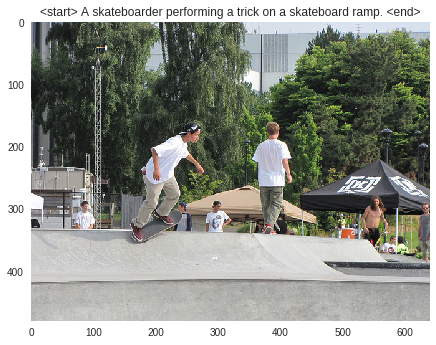

In [5]:
#@title Visualize data

tmp_img = np.array(Image.open(img_name_vector[0]))
plt.imshow(tmp_img)
plt.title(train_captions[0])
plt.grid(False)

plt.show()

### Preprocess the images using InceptionV3

In [0]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

### Initialize InceptionV3 and load the pretrained Imagenet weights

In [7]:
image_model = tf.keras.applications.InceptionV3(include_top=False, 
                                                weights='imagenet')
input_layer = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(input_layer, hidden_layer)

87916544/87910968 [==============================] - 4s 0us/step


### Storing the features extracted from InceptionV3

In [8]:
%%time

# getting the unique images
encode_train = sorted(set(img_name_vector))

# feel free to change the batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for i, (img, path) in enumerate(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, 
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    if (i+1) % 200 == 0:
        print(i+1, 'th batch', sep='')

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

200th batch
400th batch
600th batch
800th batch
1000th batch
1200th batch
1400th batch
1600th batch
CPU times: user 8min 57s, sys: 46.6 s, total: 9min 43s
Wall time: 7min 17s


### Preprocess and tokenize the captions

In [0]:
# The steps above is a general process of dealing with text processing

# choosing the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, 
                                                  oov_token="<unk>", 
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# creating the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
# Right padding
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, 
                                                           padding='post')

In [0]:
# This will find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [13]:
# find the maximum length of any caption in our dataset
# calculating the max_length 
# used to store the attention weights
max_length = calc_max_length(train_seqs)
print(max_length)

49


### Split the data into training and testing

In [14]:
# Create training and validation sets using 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector, 
                                                                    cap_vector, 
                                                                    test_size=0.2, 
                                                                    random_state=0)

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

### Create a tf.data dataset to use for training our model

In [0]:
# feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE

# shape of the vector extracted from InceptionV3 is (64, 2048)
# these two variables represent that
features_shape = 2048
attention_features_shape = 64

In [0]:
# loading the numpy files 
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap


dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# using map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]), 
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# shuffling and batching
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=
                                                                  tf.data.experimental.AUTOTUNE)

### Model

In [0]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
  
    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


In [0]:
class CNN_Encoder(tf.keras.Model):
    # Since we have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super().__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


In [0]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super().__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units, 
                                       return_sequences=True, 
                                       return_state=True, 
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


In [0]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [0]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(encoder=encoder, 
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [0]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

loss_plot = []

### Training

In [0]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
  
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
      
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
  
    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables) 

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss


In [0]:
def train(EPOCHS=20):
    
    for epoch in range(start_epoch, EPOCHS):
        start = time.time()
        total_loss = 0

        for (batch, (img_tensor, target)) in enumerate(dataset):
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss

            if batch % 100 == 0:
                print ('Epoch {} Batch {} Loss {:.4f}'.format(
                  epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
        # storing the epoch end loss value to plot later
        loss_plot.append(total_loss / num_steps)

        if epoch % 5 == 0:
            ckpt_manager.save()

        print ('Epoch {} Loss {:.6f}'.format(epoch + 1, 
                                             total_loss/num_steps))
        print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


In [28]:
train(EPOCHS=10)

Epoch 1 Batch 0 Loss 2.1976
Epoch 1 Batch 100 Loss 1.0457
Epoch 1 Batch 200 Loss 0.9412
Epoch 1 Batch 300 Loss 0.8603
Epoch 1 Loss 0.987797
Time taken for 1 epoch 265.78330278396606 sec

Epoch 2 Batch 0 Loss 0.8716
Epoch 2 Batch 100 Loss 0.7739
Epoch 2 Batch 200 Loss 0.7397
Epoch 2 Batch 300 Loss 0.7205
Epoch 2 Loss 0.732997
Time taken for 1 epoch 186.40448021888733 sec

Epoch 3 Batch 0 Loss 0.7532
Epoch 3 Batch 100 Loss 0.6907
Epoch 3 Batch 200 Loss 0.6761
Epoch 3 Batch 300 Loss 0.6725
Epoch 3 Loss 0.662339
Time taken for 1 epoch 187.74514961242676 sec

Epoch 4 Batch 0 Loss 0.6994
Epoch 4 Batch 100 Loss 0.6373
Epoch 4 Batch 200 Loss 0.6399
Epoch 4 Batch 300 Loss 0.6398
Epoch 4 Loss 0.619535
Time taken for 1 epoch 185.8539788722992 sec

Epoch 5 Batch 0 Loss 0.6578
Epoch 5 Batch 100 Loss 0.5934
Epoch 5 Batch 200 Loss 0.6054
Epoch 5 Batch 300 Loss 0.6185
Epoch 5 Loss 0.586356
Time taken for 1 epoch 186.45598483085632 sec

Epoch 6 Batch 0 Loss 0.6388
Epoch 6 Batch 100 Loss 0.5696
Epoch 6 

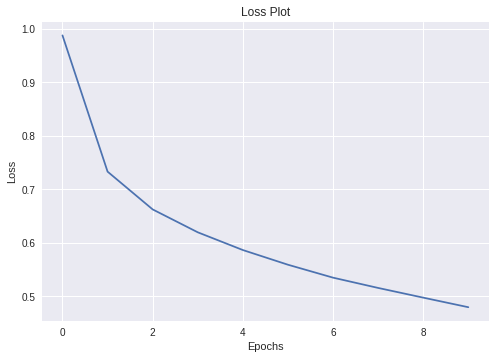

In [29]:
#@title Loss Plot
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [30]:
# 10 epochs more
train(EPOCHS=10)

Epoch 1 Batch 0 Loss 0.5176
Epoch 1 Batch 100 Loss 0.4721
Epoch 1 Batch 200 Loss 0.4665
Epoch 1 Batch 300 Loss 0.4931
Epoch 1 Loss 0.461844
Time taken for 1 epoch 187.37353348731995 sec

Epoch 2 Batch 0 Loss 0.4989
Epoch 2 Batch 100 Loss 0.4668
Epoch 2 Batch 200 Loss 0.4500
Epoch 2 Batch 300 Loss 0.4707
Epoch 2 Loss 0.446145
Time taken for 1 epoch 187.60668110847473 sec

Epoch 3 Batch 0 Loss 0.4904
Epoch 3 Batch 100 Loss 0.4572
Epoch 3 Batch 200 Loss 0.4285
Epoch 3 Batch 300 Loss 0.4553
Epoch 3 Loss 0.431217
Time taken for 1 epoch 185.98089694976807 sec

Epoch 4 Batch 0 Loss 0.5019
Epoch 4 Batch 100 Loss 0.4370
Epoch 4 Batch 200 Loss 0.4109
Epoch 4 Batch 300 Loss 0.4330
Epoch 4 Loss 0.416964
Time taken for 1 epoch 186.86449718475342 sec

Epoch 5 Batch 0 Loss 0.4832
Epoch 5 Batch 100 Loss 0.4190
Epoch 5 Batch 200 Loss 0.3930
Epoch 5 Batch 300 Loss 0.4454
Epoch 5 Loss 0.403061
Time taken for 1 epoch 185.60918545722961 sec

Epoch 6 Batch 0 Loss 0.4465
Epoch 6 Batch 100 Loss 0.4256
Epoch 6

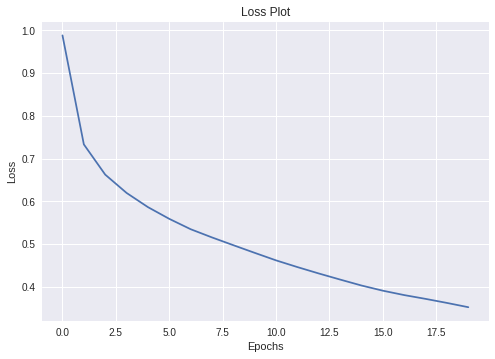

In [31]:
#@title Loss Plot
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

### Captions

* The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [0]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


In [0]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))
    
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.grid(False)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a person in jeans and black shoes riding on a skateboard <end>
Prediction Caption: a young man riding a skateboard <end>


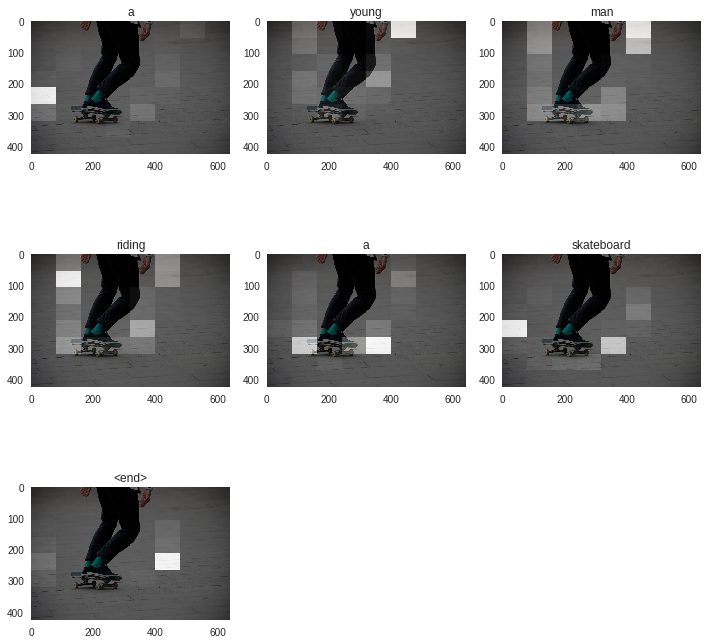

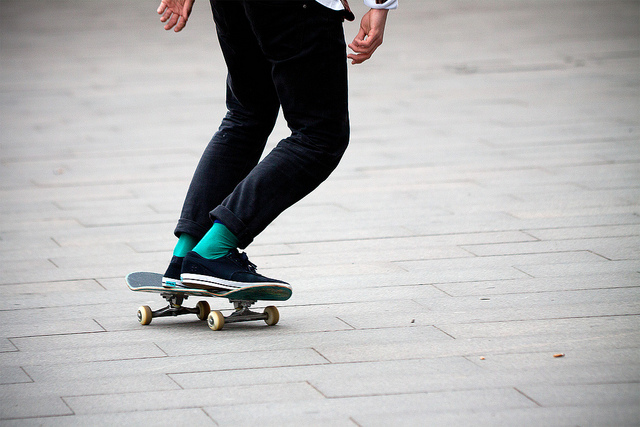

In [40]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])

Real Caption: <start> a man with a suit and tie on a motor bike <end>
Prediction Caption: a man riding a motorcycle down the street <end>


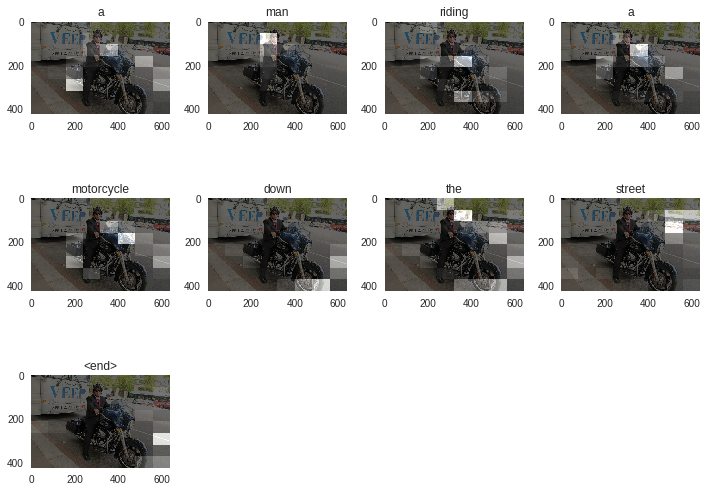

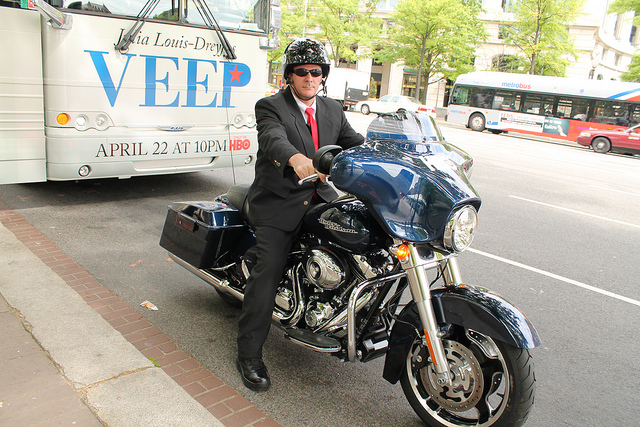

In [48]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])

Real Caption: <start> two rows of police men on motorcycles driving down a road <end>
Prediction Caption: military officers on horseback riding down a road <end>


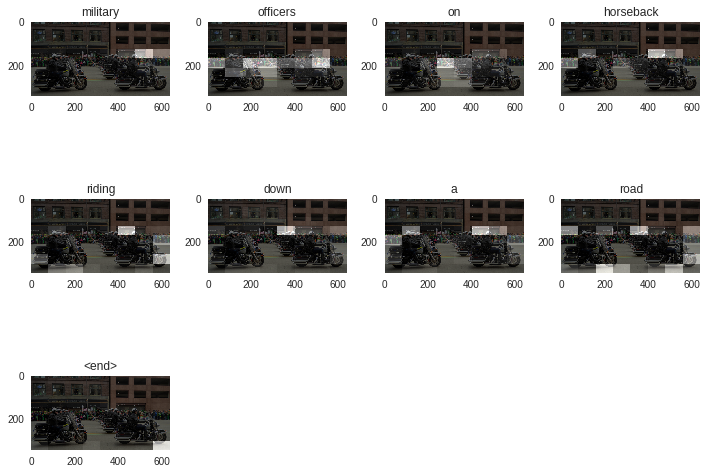

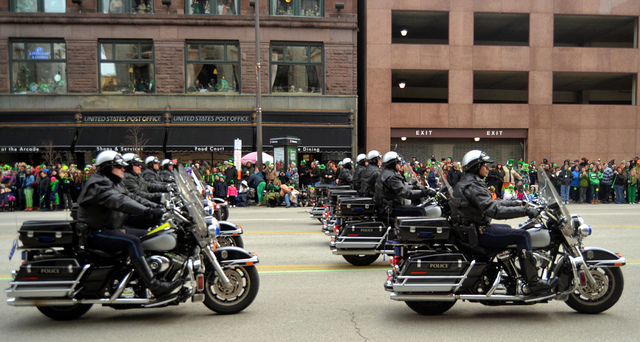

In [56]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])

In [0]:
! python -m zipfile -c checkpoints.zip checkpoints

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
!cp checkpoints.zip drive/My\ Drive/